In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
import time
import os
import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist

In [ ]:
# Подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Читаем данные из загруженной базы
df = pd.read_csv('/content/drive/My Drive/datasets/cluster/online_carts.csv') 
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Удалим первый столбец и переименнуем его
new = df.drop(['Unnamed: 0'], axis =1)
new.insert(0, column='Дата', value = [x for x in range(len(new))]) 
new = new.fillna('unknown') 
new.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,3,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,4,unknown,unknown,unknown,unknown


In [ ]:
# Здесь будут лежать все индексы строк, где есть информация в формате даты
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index) 

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Удалим строки "Период"
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Удалим пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Удалим строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Удалим ненужную колонку
new.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Выкинем превьюшные строки
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Выкинем пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Выкинем строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM")].index)        # Здесь будут лежать все индексы строк, где строка содержит флаг начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE")].index)       # Здесь будут лежать все индексы строк, где строка содержит флаг CAFRE

In [ ]:
new.head(10)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
5,01.01.2019 0:00:00,XPERT (HS71) машинка для стрижки волос,12989,1,unknown
6,01.01.2019 0:00:00,ЛП ТНА САВАЖ ПАНАШ 250 мл,988,1,unknown
7,01.01.2019 0:00:00,перчатки (50 пар) винил размер S черные,319,1,unknown
8,01.01.2019 0:00:00,Услуга доставки DPD до двери,990,1,unknown
9,01.01.2019 0:00:00,Услуга доставки СДЭК,990,1,unknown


In [ ]:
carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка
  if i in cart_list:           # Если счетчик в списке индексов-корзин
    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины
      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1     
    else:                      # Если же текущий индекс-флаг последний в спискf
      # Пробегаемся дальше по счетчику до момента, когда он не будет равен концу списка всех строк в столбце-1
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1
    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем

In [ ]:
len(carts)

13567

In [ ]:
items = 0
for cart in carts:
    for item in cart:
        items += 1
print(items)

85617


In [ ]:
print(len(carts)==len(cart_list))   # Проверка, если у нас количество корзин совпадает с количеством флагов корзин
print('Количество всех позиций: ', len(allPositions)) 
print('Пример того, что лежит в корзине: ', carts[0])

True
Количество всех позиций:  85617
Пример того, что лежит в корзине:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']


In [ ]:
for i in range(10):
    print(carts[i])

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл', 'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл', 'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.', 'Услуга доставки Почта России', '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный', '/44 Крем-краска ESTEL PRINCESS ESSEX медный', '0/00 Стойкая крем-краска чистый тон', '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный', '0/11 Крем-краска ESTEL PRINCESS ESSEX синий', '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый', '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый', '0/33 Стойкая крем-краска интенсивный золотистисты', '0/55 Крем-краска

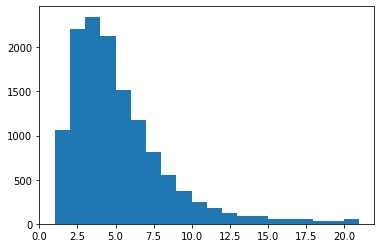

In [ ]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [ ]:
allPositions[:10]

['CONTURA (HS61) машинка для стрижки волос',
 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл',
 'Kapous Бальзам-уход для придания объема Volume up 350 мл',
 'Kapous Шампунь для придания объема Volume up 350 мл',
 'XPERT (HS71) машинка для стрижки волос',
 'ЛП ТНА САВАЖ ПАНАШ 250 мл',
 'перчатки (50 пар) винил размер S черные',
 'Услуга доставки DPD до двери',
 'Услуга доставки СДЭК',
 'OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл']

In [ ]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
print(maxPositionsCount)

6663


In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts] # Создаем список индексов для каждой корзины

n = 0                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
[1503 1732 1804 1987 2962 4226 6274 5656 5660]


In [ ]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список  
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [ ]:
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
[1503 1732 1804 1987 2962 4226 6274 5656 5660]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
%%time
cur_time = time.time()
clustersCount = 8                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)                            # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  62.3 c
CPU times: user 1min 29s, sys: 20.8 s, total: 1min 50s
Wall time: 1min 2s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)

[6 0 4 ... 3 3 6]
0 128
1 24
2 60
3 4971
4 3830
5 366
6 873
7 3315


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим насколько часто конкретная позиция появляется в данном кластере
  
  positions = []                                     # Создаем пустой список позиций
  positionValues = []                                # Создаем пустой список значений
  
  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций 
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере
  
  return positions, positionValues                   # Возвращаем список позиций кластера и количество каждой позиции

In [ ]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 128
Позиций: 2949
71% ['Услуга доставки Почта России']
66% ['Услуга доставки СДЭК']


Покупок: 24
Позиций: 864
62% ['Крем-краска для волос Studio «Kapous», оттенок 8.1 светлый пепельный блонд 100 мл']
67% ['Крем-краска для волос Studio «Kapous», оттенок 8.12 светлый пепельно-перламутровый блонд 100 мл']
79% ['Крем-краска для волос Studio «Kapous», оттенок 9.12 очень светлый пепельно-перламутровый блонд']
62% ['Крем-краска для волос Studio «Kapous», оттенок 9.21 очень светлый фиолетово-пепельный блонд 100 мл']
67% ['Услуга доставки Почта России']


Покупок: 60
Позиций: 1446
78% ['Флюид-коктейль ЖИДКИЙ ШЕЛК- 7 масел чемпионов 50 ml']
63% ['Экспресс-сыворотка для ломких,сухих, секущихся волос РАСПЛАВЛЕННЫЙ ХРУСТАЛЬ 50 ml']


Покупок: 4971
Позиций: 4982


Покупок: 3830
Позиций: 3379
100% ['Услуга доставки СДЭК']


Покупок: 366
Позиций: 1082
68% ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']
94% ['Шампунь для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']




Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
Готово разбиение на 13 классов
Готово разбиение на 14 классов
CPU times: user 20min 3s, sys: 6min 14s, total: 26min 18s
Wall time: 14min 5s


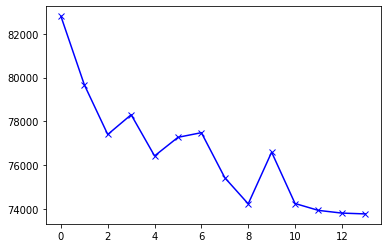

In [ ]:
%%time
cost = []
for i in range(1,15):
  kmean = KMeans(i*1) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i*1, " классов", sep="")
    
plt.plot(cost, 'bx-')

In [ ]:
max(labels)

7

In [ ]:
# Разбиение на 280 классов
for clusterNumber in range(max(labels)):                     # Пробегаем по всем значениям
    if (clusterSize[clusterNumber] > 5):                     # Если размер кластера больше 5
      pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
      print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
      print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
      pos = np.array(pos)                                      # Преобразуем в numpy
      posVal = np.array(posVal)                                # Преобразуем в numpy
      indexes = posVal > 0.2                                   # Берем индексы тех позиций, доля которых составляет больше 20%
      indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
      indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

      # Отображаем долю позиции и название самой позиции
      for i in range(len(indexedPos)):
        print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

      print()
      print()

Покупок: 128
Позиций: 2949
20% ['10/38 Стойкая крем-краскад/в яркий блонд золотисто']
21% ['10/8 Стойкая крем-краска яркий блонд жемчужный']
23% ['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
30% ['12/0 Стойкая крем-краска специальный блонд']
40% ['12/61 Стойкая крем-краска специальный блонд фиолет']
30% ['12/81 Стойкая крем-краска специальный блонд жемч']
34% ['12/89 Стойкая крем-краска специальный блонд жемчуж']
30% ['4/0 Стойкая крем-краска шатен']
20% ['4/77 Стойкая крем-краска шатен интенсивно-коричнев']
36% ['5/0 Стойкая крем-краска светлый шатен']
20% ['5/7 Стойкая крем-краска светлый шатен коричневый']
22% ['5/71 Стойкая крем-краска светлый шатен коричнево-п']
34% ['6/0 Стойкая крем-краска темный блонд']
24% ['6/1 Стойкая крем-краска темный блонд пепельный']
30% ['6/7 Стойкая крем-краска темный блонд коричневый']
29% ['6/71 Стойкая крем-краска темный блонд коричнево-пе']
26% ['6/77 Стойкая крем-краска темный блонд интенсивно-коричневый']
41% ['7/0 Ст

In [ ]:
carts_ = [[item for item in cart if not item.startswith('Услуга доставки')] for cart in carts]
len(carts_) # новый список содержит корзины, из которых удалены доставки

13567

In [ ]:
# Число позиций после удаления доставок:
items = 0
for cart in carts_:
    for item in cart:
        items += 1
print(items)

76716


In [ ]:
# Пересоздадим списки cartsIndexes and carts01:
carts, carts_ = carts_, carts # теперь в carts_ будут корзины с доставками
cartsIndexes = [labelEncoder.transform(c) for c in carts] 
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

n = 0                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']
[1503 1732 1804 1987 2962 4226 6274]
[0. 0. 0. ... 0. 0. 0.]


Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
CPU times: user 14min 31s, sys: 4min 17s, total: 18min 48s
Wall time: 10min 3s


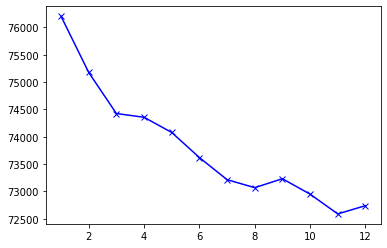

In [ ]:
# Выведите две гистограммы
# Распределения размеров классов - сколько корзин
# Распределение количества уникальных позиций в классе
# Кластеризуем по-новой (мы изменили carts01)

%%time
cost = []
for i in range(1, 13):
  kmean = KMeans(i) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i, " классов", sep="")
    
plt.plot(list(range(1, 13)), cost, 'bx-')

In [ ]:
%%time
clustersCount = 9                                   # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)
len(carts), len(carts01)

CPU times: user 1min 40s, sys: 37.6 s, total: 2min 18s
Wall time: 1min 7s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
    print(i, s)

[5 4 5 ... 5 5 5]
0 370
1 57
2 1
3 544
4 107
5 11854
6 214
7 393
8 27


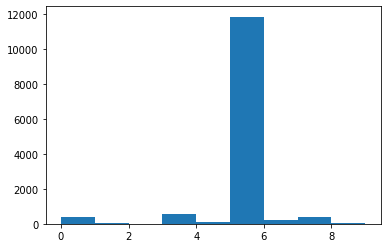

In [ ]:
_ = plt.hist(labels, clustersCount, [0, clustersCount])

In [ ]:
def printSize(cluster):
    """
    cluster: список корзин (в любом формате) 
    """
    print("Cluster has %d carts" % len(cluster))

In [ ]:
n = 2 # номер класса
cluster = [cartsIndexes[i] for i in range(len(carts)) if labels[i] == n]
items = []
for i in cluster:
    items.extend(i)
print("Cluster #%d has %d carts" % (n , len(cluster)))

Cluster #2 has 1 carts


In [ ]:
def printNumberUniqPositions(cluster):
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    print("Uniq positions:", len(uniqs))

printNumberUniqPositions(cluster)

Uniq positions: 76


In [ ]:
def printPopularPositions(cluster, level=0.2):
    N = int(level*len(cluster)) 
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    qty = {id: 0 for id in uniqs} # словарь id -> в скольких корзинах встречается позиция id
    for cart in cluster:
        for id in cart:
            qty[id] += 1
    ids20 = [id for id in uniqs if qty[id] > N] # список ids которые встретились более чем в N корзинах
    print('Позиции, которые есть минимум в %d%% корзин:' % int(100*level), ids20)

In [ ]:
printPopularPositions(cluster, level=0.2)

Позиции, которые есть минимум в 20% корзин: [2816, 2818, 2819, 2820, 2947, 5381, 2952, 2953, 5770, 4106, 1037, 3213, 271, 1296, 1297, 1298, 1299, 4370, 3093, 1301, 1180, 1565, 1566, 287, 1567, 1568, 290, 1570, 292, 4641, 1574, 4769, 5288, 1065, 5291, 44, 5293, 5805, 5404, 4792, 4546, 2812, 1479, 1481, 203, 844, 1484, 1485, 4427, 2000, 5790, 82, 1753, 1755, 1756, 1757, 4575, 5983, 2017, 2018, 2019, 2020, 2021, 5094, 744, 2030, 5743, 5486, 881, 5873, 3059, 6000, 6001, 4472, 252, 2815]


In [ ]:
printPopularPositions(cluster, level=0.02)

Позиции, которые есть минимум в 2% корзин: [2816, 2818, 2819, 2820, 2947, 5381, 2952, 2953, 5770, 4106, 1037, 3213, 271, 1296, 1297, 1298, 1299, 4370, 3093, 1301, 1180, 1565, 1566, 287, 1567, 1568, 290, 1570, 292, 4641, 1574, 4769, 5288, 1065, 5291, 44, 5293, 5805, 5404, 4792, 4546, 2812, 1479, 1481, 203, 844, 1484, 1485, 4427, 2000, 5790, 82, 1753, 1755, 1756, 1757, 4575, 5983, 2017, 2018, 2019, 2020, 2021, 5094, 744, 2030, 5743, 5486, 881, 5873, 3059, 6000, 6001, 4472, 252, 2815]


In [ ]:
printPopularPositions(cluster, level=0.01)

Позиции, которые есть минимум в 1% корзин: [2816, 2818, 2819, 2820, 2947, 5381, 2952, 2953, 5770, 4106, 1037, 3213, 271, 1296, 1297, 1298, 1299, 4370, 3093, 1301, 1180, 1565, 1566, 287, 1567, 1568, 290, 1570, 292, 4641, 1574, 4769, 5288, 1065, 5291, 44, 5293, 5805, 5404, 4792, 4546, 2812, 1479, 1481, 203, 844, 1484, 1485, 4427, 2000, 5790, 82, 1753, 1755, 1756, 1757, 4575, 5983, 2017, 2018, 2019, 2020, 2021, 5094, 744, 2030, 5743, 5486, 881, 5873, 3059, 6000, 6001, 4472, 252, 2815]


In [ ]:
maxWordsCount = 10000
tok = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
positions = []
for p in carts:
    positions.extend(p)
tok.fit_on_texts(positions)         
items = list(tok.word_index.items())

In [ ]:
positionIds = tok.texts_to_sequences(positions)
positionIds[:10]

[[4290, 4291, 967, 3, 729, 4],
 [337, 337, 763, 122, 1313, 326, 1057, 14, 2],
 [15, 17, 112, 3, 204, 95, 196, 430, 270, 2],
 [15, 6, 3, 204, 95, 196, 430, 270, 2],
 [3588, 3589, 967, 3, 729, 4],
 [364, 1288, 3360, 3361, 14, 2],
 [420, 74, 478, 575, 458, 515, 587],
 [18, 170, 125, 557, 17, 3, 4, 7, 2],
 [18, 170, 125, 6, 242, 657, 53, 37, 7, 2],
 [71, 112, 3, 120, 4, 10, 107, 98, 16, 2]]

In [ ]:
uniqPositions = set()
[uniqPositions.add(p) for p in positions]
print("Distinct positions:", len(uniqPositions))

Distinct positions: 6658


In [ ]:
def printPopularWords(cluster, level=0.2):
    pos_count = 0
    for cart in cluster:
        pos_count += len(cart) # Находим полное число позиций в кластере
    N = int(level*pos_count) # Пороговое количество позиций для слова.
    qty = {id: 0 for id in range(1, len(tok.word_index.items())+1)} # словарь id -> в скольких позициях встречается слово id
    for item in positionIds:
        for id in item:
            qty[id] += 1
    ids20 = [id for id in range(1, len(tok.word_index.items())+1) if qty[id] > N] # список ids слов, которые встретились более чем в N позициях
    words = [tok.index_word[id] for id in ids20]
    print('слова, которые есть минимум в %d%% позиций:' % int(100*level), words)

In [ ]:
printPopularWords(cluster, level=0.2)

слова, которые есть минимум в 20% позиций: ['мл', 'для', 'волос', 'крем', 'шампунь', '1000', 'краска', 'с', 'estel', 'маска', 'блонд', 'и', '250', 'kapous', '100', 'бальзам', 'ollin', '200', 'londa', 'color', '1', 'светлый', 'princess', 'essex', '6', 'блондин', 'стойкая', '0', '9', '7', '300', '500', 'пепельный', '10', 'русый', '5', 'спрей', 'otium', 'dewal', '60', '8', 'окрашенных', 'likato', 'фиолетовый', 'кондиционер', 'в', 'de', 'luxe', 'эмульсия', 'коричневый', 'studio', '3', '4', 'серии', 'гр', 'коричнево', 'шатен', 'keratin', 'оксигент', 'оттенков', '250мл', 'маслом', '12', 'фиксации', 'matrix', '150', 'classic', 'л', 'dl', 'масло', 'см', 'д', '50', 'ml', 'curex', 'интенсивного', 'светло', '2', 'пудра', 'окислительная', 'шт', '60мл', 'сыворотка', 'professional', 'oil', 'оттенок', 'темный', 'увлажнения', 'перманентная', 'очень', 'холодных', 'всех', '«kapous»', 'объема', 'мм', 'aqua', 'blonde', 'поврежденных', 'кератин', 'применения', 'серебристый', '750', 'типов', 'ежедневного', 

In [ ]:
# Искомая продвинутая функция
def printAdvanced(cluster):
    printSize(cluster)
    printNumberUniqPositions(cluster)
    printPopularPositions(cluster)
    printPopularWords(cluster)

In [ ]:
printAdvanced(cluster)

Cluster has 1 carts
Uniq positions: 76
Позиции, которые есть минимум в 20% корзин: [2816, 2818, 2819, 2820, 2947, 5381, 2952, 2953, 5770, 4106, 1037, 3213, 271, 1296, 1297, 1298, 1299, 4370, 3093, 1301, 1180, 1565, 1566, 287, 1567, 1568, 290, 1570, 292, 4641, 1574, 4769, 5288, 1065, 5291, 44, 5293, 5805, 5404, 4792, 4546, 2812, 1479, 1481, 203, 844, 1484, 1485, 4427, 2000, 5790, 82, 1753, 1755, 1756, 1757, 4575, 5983, 2017, 2018, 2019, 2020, 2021, 5094, 744, 2030, 5743, 5486, 881, 5873, 3059, 6000, 6001, 4472, 252, 2815]
слова, которые есть минимум в 20% позиций: ['мл', 'для', 'волос', 'крем', 'шампунь', '1000', 'краска', 'с', 'estel', 'маска', 'блонд', 'и', '250', 'kapous', '100', 'бальзам', 'ollin', '200', 'londa', 'color', '1', 'светлый', 'princess', 'essex', '6', 'блондин', 'стойкая', '0', '9', '7', '300', '500', 'пепельный', '10', 'русый', '5', 'спрей', 'otium', 'dewal', '60', '8', 'окрашенных', 'likato', 'фиолетовый', 'кондиционер', 'в', 'de', 'luxe', 'эмульсия', 'коричневый', 's